# ATE computations from Baysian Networks in Observational Data

*This notebook aims to study the capabilities of Bayesian Networks for computing Average Treatment Effects (ATE) from Observational Data under the Neyman-Rubin potential outcome framework.*

In contrast to randomized controlled trials (RCTs) where the ignorability assumption is satisfied, estimating treatment effects from observational data introduces additional complexities.

Under RCT conditions, an unbiased estimator of the Average Treatment Effect (ATE) can be effectively computed by comparing the means of the observed treated subjects and the observed untreated subjects.

Specifically, $ \mathbb{E} [Y|T=t] = \mathbb{E} [Y(t)|T=t]$ under the Stable-Unit-Treatment-Value Assumption (STUVA), which posits that $ Y = (1-T)Y(0) + TY(1) $. Furthermore, $ \mathbb{E}[Y(t)|T=t] = \mathbb{E}[Y(t)]$ under the Ignorability assumption $ T \perp\!\!\!\perp \{Y(0), Y(1)\} $. 

Therefore the ATE is given by $\tau = \mathbb{E}[Y(1)] - \mathbb{E}[Y(0)] =  \mathbb{E}[Y|T=1] - \mathbb{E}[Y|T=0]$ and this difference can be estimated directly from the data.

However, in observational data, the ignorability assumption often does not hold, as subjects with certain treatment outcomes may be more or less likely to receive the treatment (i.e. $ \mathbb{E}[Y(t)|T=t] \neq \mathbb{E}[Y(t)], \ t \in \{0,1\}$). Previous estmation methods are not guaranteed to be unbiased. 

Nevertheless, it may be possible to identify subject characteristics related to both potential response and treatment exposure, referred to as confounders. If we make the assumptions that the convariate vector $\boldsymbol{X}$ contains all such confounders, we obtain conditional independence between the treatment and the potential outcomes given the covariates:

$$T \perp \!\!\! \perp \{ Y(0), Y(1)\} \ | \ \boldsymbol{X}$$

This allows for the estimation of the ATE from observational data. 

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, logistic

## 1 - Generated Data

* The *outcome* variable $Y$ is generated according the following equation:
$$ \begin{align*} 
Y & = - X_1 + X_2 - X_3 +2 T -V_1 + V_2 + V_3 \\
  & = \langle \nu , \boldsymbol{Z} \rangle + \langle \xi, \boldsymbol{V} \rangle
\end{align*}$$

Where $\nu = (0, -1, 1, -1, 2)^\intercal$, $\boldsymbol{Z} = (1, X_1, X_2, X_3, T)^\intercal$, $\xi = (-1,1,1)^\intercal$ and $\boldsymbol{V} = (V_1, V_2, V_3)^\intercal$. 

* The *covariates* are distributed as $X_3 \sim \text{Bernoulli}\left(0.2\right)$. Conditionally $X_3$, the distribution of the other variables is defined as:

If $X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{0}, \Sigma)$ 

If $ X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right) \ \text{and} \ \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

* The *treatment* $T$ is generated as a Bernoulli of the *propensity score*:
$$ \begin{align*}
\mathbb{P}[T=1|X] &= e\left(X, \beta\right) \\
&= (1+\exp (-0.6 X_{1} +0.6 X_{2} - 0.6 X_{3}))^{-1} \\
&= \frac{1}{1+e^{-\langle \beta , \boldsymbol{X} \rangle}} \\
\mathbb{P}[T=0|X] &= 1-\mathbb{P}[T=1|X]
\end{align*}$$
With $\beta = {\left(0, 0.6, -0.6, 0.6\right)}^{\intercal}$ and $\boldsymbol{X} = (1, X_1, X_2, X_3)^{\intercal}$.

In [30]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

Here, the exact ATE can be explicitly calculated using the previously defined assumptions.

$$ \begin{align*}
\mathbb{E}[Y(1) - Y(0)] &= \mathbb{E}_X [ \mathbb{E}[Y(1) - Y(0) | X] ] \\
&= \mathbb{E}_X [ \mathbb{E}[Y|X, T=1] - \mathbb{E}[Y|X, T=0] ] \\
&= \mathbb{E}_X [ (- X_1 + X_2 - X_3 + 2 \times 1 -V_1 + V_2 + V_3) - (- X_1 + X_2 - X_3 + 2 \times 0 -V_1 + V_2 + V_3 ) ] \\
&= 2
\end{align*} $$

In [31]:
df = generate_lunceford(int(1e6))
df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,-1.616180,1.067599,0,0,-0.069950,1.468590,0,3.797725
1,-2.105981,1.495745,0,0,-0.844997,2.290955,0,6.656497
2,0.731012,-0.902341,0,1,-0.286704,0.305420,1,3.635370
3,0.652966,-2.059109,0,1,1.708628,-1.958316,0,-3.219897
4,1.444891,-1.115798,1,0,1.636743,-1.326875,1,-5.064691


### 1.1 - "Exact" Computation

In [23]:
def getBN(# Covariate parameters
          covariate_start : int = -5.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          # Outcome parameters
          outcome_start = -10.0 ,
          outcome_end = 15.0 ,
          outcome_num_split = 60,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True,
          fill_distribution : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        plus = "" if fill_distribution else "+"
        bn = gum.BayesNet()
        for i in range(1,3):
            bn.add(f"X{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
            bn.add(f"V{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add(f"X3[2]")
        bn.add(f"V3[2]")
        bn.add("T[2]")
        bn.add(f"Y{plus}[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("X3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("V3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("T", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        for X in ["X1", "X2", "X3"]:
            bn.addArc(X, "T")
        for XV in ["X1", "V1", "X2", "V2"]:
            bn.addArc("X3", XV)
        bn.addArc("X3", "V3")
        bn.endTopologyTransformation()

    if add_arcs and fill_distribution:
        bn.cpt("X3").fillWith([0.8, 0.2])
        bn.cpt("V3")[:] = [[0.75, 0.25], [0.25, 0.75]]
        for XV in ["X", "V"]:
            bn.cpt(f"{XV}1").fillFromDistribution(norm, loc="2*X3-1", scale=1)
            bn.cpt(f"{XV}2").fillFromDistribution(norm, loc="1-2*X3", scale=1)
        bn.cpt("T").fillFromDistribution(logistic, loc="-0.6*X1+0.6*X2-0.6*X3", scale=1)
        bn.cpt("Y").fillFromDistribution(norm, loc="-X1+X2-X3+2*T-V1+V2+V3", scale=1)

    return bn

In [6]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents("T"):
        res.eraseArc(p_id, bn.idFromName("T"))
    return res

def ATE(bn : gum.BayesNet) -> float:
    """
    Returns estimation of the ATE directly from Baysian Network.
    """

    ie = gum.LazyPropagation(mutilateBN(bn))

    ie.setEvidence({"T": 0})
    ie.makeInference()
    p0 = ie.posterior("Y")

    ie.chgEvidence("T",1)
    ie.makeInference()
    p1 = ie.posterior("Y")

    dif = p1 - p0
    return dif.expectedValue(lambda d: dif.variable(0).numerical(d[dif.variable(0).name()]))

In [7]:
exbn = getBN()

In [8]:
gnb.sideBySide(gnb.getInference(mutilateBN(exbn), evs={"T": 0}, size="10"),
               gnb.getInference(mutilateBN(exbn), evs={"T": 1}, size="10"),
               captions=["Y(0)", "Y(1)"])

print(exbn)
print(f"{ATE(exbn) = }")

BN{nodes: 8, arcs: 15, domainSize: 10^6.68124, dim: 4720275, mem: 36Mo 639Ko 816o}
ATE(exbn) = 1.9978279940014116


### Parameter Learning

In [55]:
discretized_p_template = getBN(data=df)

In [56]:
disc_p_learner = gum.BNLearner(df, discretized_p_template)
disc_p_learner.useNMLCorrection()
disc_p_learner.useSmoothingPrior(1e-9)

disc_plbn = gum.BayesNet(discretized_p_template)
disc_p_learner.fitParameters(disc_plbn)

print(disc_p_learner)

Filename       : /tmp/tmpuo8t4c61.csv
Size           : (1000000,8)
Variables      : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [57]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_plbn), evs={"T":0}, size="50"),
               gnb.getInference(mutilateBN(disc_plbn), evs={"T":1}, size="50"),
               captions=["Y(0)", "Y(1)"])

print(f"{ATE(disc_plbn) = }")

ATE(disc_plbn) = 1.7512799195954818


In [58]:
custom_p_template = getBN(fill_distribution=False)

In [59]:
cstm_p_learner = gum.BNLearner(df, custom_p_template)
cstm_p_learner.useNMLCorrection()
cstm_p_learner.useSmoothingPrior(1e-9)

cstm_plbn = gum.BayesNet(custom_p_template)
cstm_p_learner.fitParameters(cstm_plbn)

print(cstm_p_learner)

Filename       : /tmp/tmpnxtmhavo.csv
Size           : (1000000,8)
Variables      : X1[10], V1[10], X2[10], V2[10], X3[2], V3[2], T[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [60]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_plbn), evs={"T":0}, size="50"),
               gnb.getInference(mutilateBN(cstm_plbn), evs={"T":1}, size="50"),
               captions=["Y(0)", "Y(1)"])

print(f"{ATE(cstm_plbn) = }")

ATE(cstm_plbn) = 1.7300872751924388


In [61]:
p_template = custom_p_template

num_obs_list = [5e4, 1e5, 5e5, 1e6]
num_shots = 10
pl_tau_hat_arr = list()

for i in num_obs_list:
    pl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        p_learner = gum.BNLearner(df, p_template)
        p_learner.useNMLCorrection()
        p_learner.useSmoothingPrior(1e-9)

        plbn = gum.BayesNet(p_template)
        p_learner.fitParameters(plbn)

        pl_tau_hat_arr[-1].append(ATE(plbn))

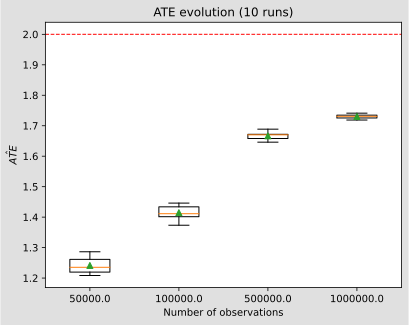

In [62]:
plt.boxplot(pl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.show()

### 3 - Structure Learning

In [63]:
discretized_s_template = getBN(data=df, add_arcs=False)

In [64]:
disc_s_learner = gum.BNLearner(df, discretized_s_template)
disc_s_learner.useNMLCorrection()
disc_s_learner.useSmoothingPrior(1e-6)
disc_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
disc_slbn = disc_s_learner.learnBN()

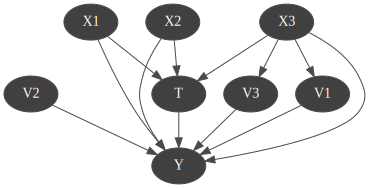

In [65]:
gnb.showBN(disc_slbn, size="50")

In [66]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_slbn), evs={"T":0}, size="10"),
               gnb.getInference(mutilateBN(disc_slbn), evs={"T":1}, size="10"),
               captions=["Y(0)", "Y(1)"]) 

ATE(disc_slbn)

1.5670350948081344

In [67]:
custom_s_template = getBN(fill_distribution=False, add_arcs=False)

In [68]:
cstm_s_learner = gum.BNLearner(df, custom_s_template)
cstm_s_learner.useNMLCorrection()
cstm_s_learner.useSmoothingPrior(1e-6)
cstm_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
cstm_slbn = cstm_s_learner.learnBN()

In [69]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_slbn), evs={"T":0}, size="10"),
               gnb.getInference(mutilateBN(cstm_slbn), evs={"T":1}, size="10"),
               captions=["Y(0)", "Y(1)"]) 

ATE(cstm_slbn)

1.5532443024497282

In [70]:
template = custom_template

num_obs_list = [5e4, 1e5, 5e5, 1e6]
num_shots = 10
sl_tau_hat_arr = list()

for i in num_obs_list:
    sl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        s_learner = gum.BNLearner(df, template)
        s_learner.useNMLCorrection()
        s_learner.useSmoothingPrior(1e-6)
        s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
        slbn = s_learner.learnBN()

        sl_tau_hat_arr[-1].append(ATE(slbn))

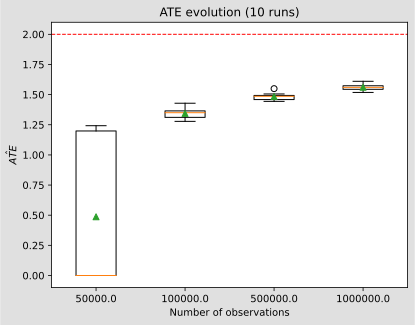

In [71]:
plt.boxplot(sl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.show()